<a href="https://colab.research.google.com/github/snu-digital-finance/ProductionML/blob/main/Library_Simplify_ProductionML_1027_%EB%8F%8C%EC%95%84%EA%B0%91%EB%8B%88%EB%8B%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library (close)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# === 1. Data ===
np.random.seed(42)
tf.random.set_seed(42)

n = 1000
noise_scale = 0.05

# K-intensive: K~U(0,1), L=0
K = np.random.rand(n, 1)
L0 = np.zeros((n, 1))
X_K = np.hstack([K, L0])

# L-intensive: K=0, L~U(0,1)
K0 = np.zeros((n, 1))
L = np.random.rand(n, 1)
X_L = np.hstack([K0, L])

# Targets with noise
y1 = K**3 + np.random.normal(0, noise_scale, size=(n, 1))      # K³ + noise
y2 = -K**3 + np.random.normal(0, noise_scale, size=(n, 1))     # −K³ + noise
y3 = L**3 + np.random.normal(0, noise_scale, size=(n, 1))      # L³ + noise
y4 = -L**3 + np.random.normal(0, noise_scale, size=(n, 1))


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Lambda

# Original Model - 5 layer trained on y1
def build_model():
    model = Sequential([
        tf.keras.Input(shape=(2,)),
        Lambda(tf.nn.relu, name="input_relu"),
        Dense(8, activation="relu"),
        Dense(8, activation="relu"),
        Dense(8, activation="relu"),
        Dense(1, activation="linear")
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

model = build_model()
model.fit(X_K, y1, epochs=100, batch_size=32, verbose=0)
model.summary()

In [ ]:
# TL Model 1 - Train on y1 data -> Transfer Learning to y2 data (last 2 layers)
model_tf_y2 = Sequential()
for i in range(3):
    layer = model.layers[i]
    layer.trainable = False
    model_tf_y2.add(layer)

model_tf_y2.add(Dense(8, activation="relu"))
model_tf_y2.add(Dense(1))
model_tf_y2.compile(optimizer="adam", loss="mse")

model_tf_y2.fit(X_K, y2, verbose=0, epochs=100, batch_size=32)

# TL Model 2 - Train on y1 data -> Transfer Learning to y3 data (last 2 layers)
model_tf_y3 = Sequential()
for i in range(3):
    layer = model.layers[i]
    layer.trainable = False
    model_tf_y3.add(layer)

model_tf_y3.add(Dense(8, activation="relu"))
model_tf_y3.add(Dense(1))
model_tf_y3.compile(optimizer="adam", loss="mse")

model_tf_y3.fit(X_L, y3, verbose=0, epochs=100, batch_size=32)

# Feature Norm

## Helpers (close)

### Feature Path Functions

In [14]:
import matplotlib.style as style

# Set random seed for reproducibility
np.random.seed(42); tf.random.set_seed(42)
rng = np.random.default_rng(42)
style.use('tableau-colorblind10')
plt.rcParams.update({
    'font.size': 14, 'figure.titlesize': 18, 'figure.titleweight': 'bold',
    'figure.subplot.hspace': 0.3, 'figure.subplot.wspace': 0.3, 'axes.titlesize': 14, 'axes.labelsize': 13, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'legend.fontsize': 12,
})


# --------------------------
# 1) Robust mask computation
# --------------------------
def get_relu_keep_probs_aligned(model, X_batch):
    """
    Compute per-weight-layer ReLU pass probabilities p = P(z>0).
    Returns:
      masks: list of numpy arrays (or None) for each weight-containing layer (in order encountered)
      layer_indices: list of model.layers indices that correspond to each mask (alignment info)
    Notes:
      - X_batch: tf.Tensor shape (batch, input_dim), representative batch
      - Safe for models that include Activation/Lambda/Dropout/etc.
    """
    X = tf.identity(X_batch)
    masks, layer_indices = [], []

    for idx, layer in enumerate(model.layers):
        ws = layer.get_weights()
        if len(ws) == 0:
            try: # no weights -> forward propagate to update X for subsequent layers
                X = layer(X)
            except Exception:
                # fallback: if layer defines 'activation' wrapper, apply it; else skip
                act = getattr(layer, "activation", None)
                if act is not None:
                    X = act(X)
            continue

        # layer has weights (e.g., Dense). compute pre-activation z = X @ W + b (if present)
        W = ws[0]
        W_tf = tf.convert_to_tensor(W, dtype=tf.float32)
        z = tf.matmul(X, W_tf)
        if len(ws) > 1:
            b_tf = tf.convert_to_tensor(ws[1], dtype=tf.float32)
            z = z + b_tf  # broadcast

        act = getattr(layer, "activation", None)
        masks.append(
            tf.reduce_mean(tf.cast(z > 0.0, tf.float32), axis=0).numpy()
            if (act == tf.keras.activations.relu) else None)
        layer_indices.append(idx)

        try: # propagate X using the actual layer (so next z computed correctly)
            X = layer(X)
        except Exception:
            X = act(z) if act is not None else z


    return masks, layer_indices

def compute_forward_path(
     Ws, Bs, i,
     dense_layer_indices, layer_idxs,
     masks, include_bias=False
):
    input_dim = Ws[0].shape[0]
    if not (0 <= i < input_dim):
        raise ValueError(f"feature index i out of range: i={i}, input_dim={input_dim}")

    # one-hot input e
    e = np.zeros(input_dim, dtype=np.float64)
    e[i] = 1.0

    path, v = [], None
    for k, W in enumerate(Ws):
        if v is None:
            # first weight-layer: contribution e @ W
            v = e @ W  # shape (out_dim,)
        else:
            # find mask position for prev_layer_idx inside dense_layer_indices
            mask_prev = None
            try:  # apply mask corresponding to previous weight-layer (if exists)
                pos = dense_layer_indices.index(layer_idxs[k-1])
                mask_prev = masks[pos]  # might be None
            except ValueError:
                mask_prev = None

            if mask_prev is not None:
                v = v * mask_prev  # elementwise
            v = v @ W # propagate to next layer

        if include_bias and Bs[k] is not None:
            v = v + Bs[k]
        path.append(v.copy())
        print(path[-1].shape, sum(path[-1]**2)**(0.5))
    return path

def layer_stats(path):
  layer_L1 = [np.sum(np.abs(x)) for x in path]
  total = sum(layer_L1) if sum(layer_L1) != 0 else 1.0
  layer_pct = [x / total for x in layer_L1]
  layer_units = [x.shape[0] for x in path]
  return layer_L1, layer_pct, layer_units


# --------------------------
# 2) Feature path computation
# --------------------------
def feature_path(model, i, X_batch, include_bias=False):
    """
    Returns list [v^(1), v^(2), ...] for feature i (one-hot input).
    - X_batch: representative batch (tf.Tensor) for mask estimation
    - include_bias: if True, add layer bias to v^(k) (usually False for 'feature contribution' view)
    The returned path aligns with weight-containing layers only.
    Also returns metadata in dict form.
    """
    masks, dense_layer_indices = get_relu_keep_probs_aligned(model, X_batch)

    # gather weights (+bias optionally) for weight-containing layers, in same encountered order
    Ws, Bs, layer_idxs = [], [], []
    for idx, layer in enumerate(model.layers):
        ws = layer.get_weights()
        if len(ws) == 0:
            continue
        Ws.append(ws[0].astype(np.float64))
        Bs.append((ws[1].astype(np.float64) if (include_bias and len(ws) > 1) else None))
        layer_idxs.append(idx)

    if len(Ws) == 0:
        raise ValueError("Model has no weight-containing layers.")

    path = compute_forward_path(
        Ws, Bs, i, dense_layer_indices,
        layer_idxs, masks, include_bias
    )

    layer_L1, layer_pct, layer_units = layer_stats(path)

    return {
        "path": path,
        "layer_L1": layer_L1,
        "layer_pct": layer_pct,
        "layer_units": layer_units,
        "layer_idxs": layer_idxs,
        "masks": masks,
        "dense_layer_indices": dense_layer_indices
    }


In [15]:
# --------------------------
# 3) Plot helper (no external fm/sp)
# --------------------------
def plot_feature_path(model, num_features, X_batch, vmin=None, vmax=None, cmap='cividis'):
    """
    Plot heatmaps per feature (rows) x weight-layer (cols) and a norm-evolution plot.
    - num_features: how many feature indices [0..num_features-1] to show (rows)
    - X_batch: representative batch for mask computation
    - vmin/vmax: optional fixed color scale; if None scale per whole figure
    """
    # compute all feature paths
    feat_vecs = [feature_path(model, i, X_batch)['path'] for i in range(num_features)]
    cols = len(feat_vecs[0])
    rows = num_features

    # compute global vmin/vmax if not provided
    all_vals = np.concatenate([v.flatten() for row in feat_vecs for v in row])
    if vmin is None:
        vmin = all_vals.min()
    if vmax is None:
        vmax = all_vals.max()
    # symmetric colorbar around 0 if values roughly symmetric
    absmax = max(abs(vmin), abs(vmax))
    vmin, vmax = -absmax, absmax

    fig, axes = plt.subplots(rows, cols, figsize=(2.8*cols, 1.2*rows), squeeze=False)
    fig.suptitle("Feature influence (rows=features, cols=weight-layers)", fontsize=14)

    layer_titles = [f"Weight-layer {k+1}\n(out={feat_vecs[0][k].shape[0]})" for k in range(cols)]

    for i, vecs in enumerate(feat_vecs):
        for k, v in enumerate(vecs):
            ax = axes[i][k]
            ax.imshow(v[np.newaxis, :], aspect='auto', vmin=vmin, vmax=vmax, cmap=cmap)
            if i == 0:
                ax.set_title(layer_titles[k], fontsize=10)
            if k == 0:
                ax.set_ylabel(f"feat {i+1}", fontsize=9)
            ax.set_yticks([])
            ax.set_xticks([])

    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.02)
    cbar.set_label("influence value")

    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    plt.show()

    # norm-evolution plot
    plt.figure(figsize=(6,3))
    for i, vecs in enumerate(feat_vecs):
        norms = [np.linalg.norm(v, 2) for v in vecs]
        plt.plot(range(2, cols+2), norms, marker='o', label=f"feat {i+1}")
    plt.xlabel("weight-layer index")
    plt.ylabel("||influence||_2")
    plt.title("Feature influence norm by layer")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.ylim(0, 2.0)
    plt.show()


### Back Propagation Functions

In [16]:
# -------------------------
# simple activations (numpy)
# -------------------------
def relu(z):
    return np.maximum(0.0, z)

def drelu(z):
    """Derivative of ReLU: 1 if z>0 else 0 (elementwise)."""
    return (z > 0).astype(float)

# -------------------------
# forward / backprop (single-example, row-vector convention)
# -------------------------
def forward_collect(x, Ws, acts):
    """
    x: 1D array shape (in_dim,)
    Ws: list of weight arrays, each shape (in_dim_l, out_dim_l)
    acts: list of strings per layer, e.g. ['relu', 'linear', ...]
    Returns: zs (list of pre-activations), as_ (list of activations)
    """
    zs, as_, a = [], [], x
    for W, act in zip(Ws, acts):
        z = a @ W # row-vector convention
        a = relu(z) if act == "relu" else z
        zs.append(z); as_.append(a)
    return zs, as_


def backprop_signals(x, y_target, Ws, acts):
    """
    Single-example backprop returning delta_a and delta_z lists.
    x: 1D array (in_dim,)
    y_target: 1D array (out_dim,)
    Ws: list of weight matrices (in_dim_l, out_dim_l)
    acts: list of activation names aligned with Ws
    """
    zs, as_ = forward_collect(x, Ws, acts)
    y = as_[-1]

    L = len(Ws)
    delta_a, delta_z = [None]*L, [None]*L

    # (A): dL/da^L for MSE: (y - y_target)
    delta_a[-1] = (y - y_target)
    delta_z[-1] = delta_a[-1] * (drelu(zs[-1]) if acts[-1] == "relu" else 1.0)

    for l in range(L-2, -1, -1):
        # (B): propagate delta_a backward: (row-vector) = delta_z[next] @ W_next.T
        delta_a[l] = delta_z[l+1] @ Ws[l+1].T
        delta_z[l] = delta_a[l] * (drelu(zs[l]) if acts[l] == "relu" else 1.0)
    return dict(delta_a=delta_a, delta_z=delta_z)


In [17]:
# -------------------------
# model parameter extractor (Keras -> numpy)
# -------------------------
def get_model_params(model):
    Ws, acts = [], []
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
              Ws.append(np.asarray(layer.get_weights()[0]))
              acts.append("relu" if layer.activation == tf.keras.activations.relu else None)
    return Ws, acts

# -------------------------
# utility: ensure rows = samples
# -------------------------
def rows_are_samples(X, in_dim):
    X = np.asarray(X, dtype=float)
    if X.ndim != 2:
        raise ValueError("X must be 2D (samples x features)")
    if X.shape[1] == in_dim:   # already (N, in_dim)
        return X
    if X.shape[0] == in_dim:   # transposed (in_dim, N)
        return X.T
    raise ValueError(f"Neither axis matches in_dim={in_dim}. Got {X.shape}.")

from mpl_toolkits.mplot3d import Axes3D  # registers 3D projection
from matplotlib import colors, cm

# -------------------------
# main plotting function
# -------------------------
def plot_delta_flow(model, X, subtitle='', zmax=None, y_scale=1.0):
    """
    Plot ||delta_z||_2 per layer for selected samples.
    - model: tf.keras Model (dense layers)
    - X: array-like, samples x features (or transposed)
    - sample_indices: None (use all) or iterable of indices to plot
    - returns (fig, ax)
    """
    Ws, acts = get_model_params(model)
    if len(Ws) == 0:
        raise ValueError("No dense/kernel layers found in model.")

    in_dim, out_dim = Ws[0].shape[0], Ws[-1].shape[1]
    X_row = rows_are_samples(X, in_dim)
    N = X_row.shape[0]
    if N == 0:
        raise ValueError("No samples selected for plotting (check sample_indices).")

    idxs = list(range(N))
    y_target = np.zeros(out_dim, dtype=float)
    norms_list = []
    # compute per-sample norms
    for c in idxs:
        out = backprop_signals(X_row[c].ravel(), y_target, Ws, acts)
        dzs = out["delta_z"]
        norms_list.append(np.array([np.linalg.norm(dz) for dz in dzs], dtype=float))
    print(c, list(map(lambda x: np.sum(x**2)**(0.5), dzs)), norms_list[-1])
    norms_mat = np.vstack(norms_list)  # (S, L)
    S, L = norms_mat.shape
    layers = np.arange(2, L+2)

    # plotting
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    fig.suptitle(f'Backprop Signal Norms\n{subtitle}', fontsize=14)

    norm = colors.Normalize(vmin=0, vmax=max(S-1, 1))
    cmap = plt.get_cmap('cividis')
    for s in range(S):
        y_vals = np.full(L, s * y_scale)
        z_vals = norms_mat[s]
        ax.plot(layers, y_vals, z_vals, color=cmap(norm(s)), linewidth=1.5, alpha=0.7)
        idx_max = int(np.argmax(z_vals))
        ax.scatter(layers[idx_max], y_vals[idx_max], z_vals[idx_max],
                   color='red', s=30, marker='o', depthshade=True)

    ax.set_xlabel("Layer"); ax.set_ylabel("Sample Index"); ax.set_zlabel("||δ_z||₂")
    if zmax is not None:
        ax.set_zlim(0, zmax)

    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(np.arange(S))
    fig.colorbar(mappable, ax=ax, pad=0.1, label='Sample Index (ordered)')

    plt.tight_layout(); plt.show()
    return fig, ax


### ReLU Location Feature Path Function

In [18]:
from tensorflow.keras.layers import Dense, Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def build_single_relu(where: str):
    """
    Build a network with exactly one ReLU placed at a specified location.
    Architecture: Input → Hidden(8) → Hidden(8) → Hidden(8) → Output(1, linear)
    - 'where' ∈ {'input', 'h1', 'h2', 'h3'}
      * 'input' : ReLU applied on the raw input via a Lambda layer
      * 'h1'    : ReLU as activation of the 1st hidden Dense
      * 'h2'    : ReLU as activation of the 2nd hidden Dense
      * 'h3'    : ReLU as activation of the 3rd hidden Dense
    All other layers use linear activation.
    """
    assert where in {"input", "h1", "h2", "h3"}

    layers = []

    # Input (optionally with ReLU on the input)
    if where == "input":
        layers += [tf.keras.Input(shape=(2,)), Lambda(tf.nn.relu, name="input_relu")]
    else:
        layers += [tf.keras.Input(shape=(2,))]

    # Hidden 1
    act1 = "relu" if where == "h1" else "linear"
    layers += [Dense(8, activation=act1, name="dense1")]

    # Hidden 2
    act2 = "relu" if where == "h2" else "linear"
    layers += [Dense(8, activation=act2, name="dense2")]

    # Hidden 3
    act3 = "relu" if where == "h3" else "linear"
    layers += [Dense(8, activation=act3, name="dense3")]

    # Output (always linear for regression)
    layers += [Dense(1, activation="linear", name="out")]

    model_relu = Sequential(layers)
    model_relu.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")
    return model_relu


def run_single_relu_experiment(X, y, x_scalar, xlabel, title_prefix,
                               epochs=300, batch_size=64):
    """
    Train/test with identical splits and compare single-ReLU models
    where the only ReLU is placed at: input / h1 / h2 / h3.
    Also plot pairwise differences relative to the Input-ReLU model.
    """
    # --- fixed split for fair comparison ---
    X_tr, X_te, y_tr, y_te, x_tr, x_te = train_test_split(
        X, y, x_scalar, test_size=0.3, random_state=42
    )

    # --- evaluation grid along the active axis ---
    g = np.linspace(0, 1, 400).reshape(-1, 1)
    if xlabel == "K":
        X_grid = np.hstack([g, np.zeros_like(g)])
        y_grid_true = g**3
    else:  # xlabel == "L"
        X_grid = np.hstack([np.zeros_like(g), g])
        y_grid_true = g**3

    # --- build & train 4 models (different single ReLU locations) ---
    models_relu = {
        "Input-ReLU": build_single_relu("input"),
        "H1-ReLU":    build_single_relu("h1"),
        "H2-ReLU":    build_single_relu("h2"),
        "H3-ReLU":    build_single_relu("h3"),
    }
    preds_grid = {}
    test_mse = {}

    for name, m in models_relu.items():
        m.fit(X_tr, y_tr, epochs=epochs, batch_size=batch_size, verbose=0)
        y_te_pred = m.predict(X_te, verbose=0)
        test_mse[name] = mean_squared_error(y_te, y_te_pred)
        preds_grid[name] = m.predict(X_grid, verbose=0).ravel()

    # pretty print MSEs
    mse_str = ", ".join([f"{k}: {v:.6f}" for k, v in test_mse.items()])
    print(f"[{title_prefix}] Test MSE — {mse_str}")

    # --- (A) prediction curves on grid ---
    plt.figure(figsize=(12, 5))
    plt.plot(g, y_grid_true, lw=2, label="True (noiseless)")
    for name, pred in preds_grid.items():
        plt.plot(g, pred, lw=2, label=name)
    plt.xlim(0, 1)
    plt.xlabel(xlabel); plt.ylabel("y")
    plt.title(f"[{title_prefix}] Single-ReLU location: prediction curves")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    # --- (B) difference curves w.r.t. Input-ReLU ---
    base = preds_grid["Input-ReLU"]
    plt.figure(figsize=(12, 4))
    plt.plot(g, preds_grid["H1-ReLU"] - base, label="(H1 - Input)")
    plt.plot(g, preds_grid["H2-ReLU"] - base, label="(H2 - Input)")
    plt.plot(g, preds_grid["H3-ReLU"] - base, label="(H3 - Input)")
    plt.axhline(0, color="black", lw=1)
    plt.xlim(0, 1)
    plt.xlabel(xlabel); plt.ylabel("Δ Prediction")
    plt.title(f"[{title_prefix}] Differences relative to Input-ReLU")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    return models_relu, X_tr  # X_tr can be reused as a representative batch for plot_feature_path


## Run Feature Norm

### Plot Feature Path

(8,) 1.181312478381242
(8,) 1.4756474009894762
(8,) 0.9823955604080864
(1,) 0.6267866715955153
(8,) 1.2722922810269117
(8,) 0.8142225568151977
(8,) 0.6047428579275679
(1,) 0.26382405483654614


/tmp/ipython-input-4192965540.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.95])


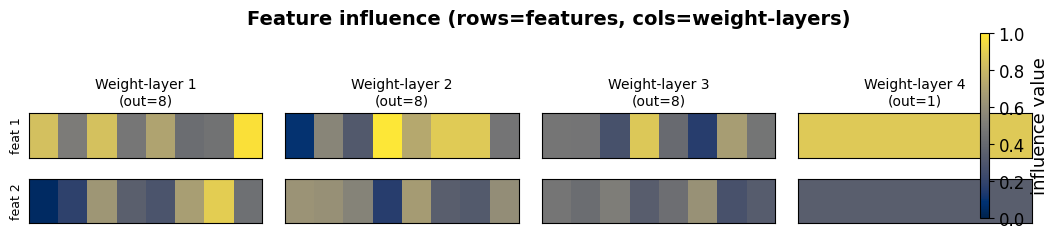

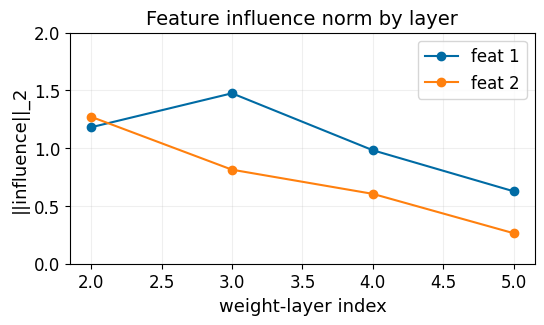

In [19]:
plot_feature_path(model, num_features=2, X_batch=X_K)

(8,) 1.181312478381242
(8,) 0.5435265620178237
(8,) 0.7604401314545486
(1,) 0.14641073608199873
(8,) 1.2722922810269117
(8,) 0.8610910752848558
(8,) 0.7092501883317424
(1,) 1.0207549364617399


/tmp/ipython-input-4192965540.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.95])


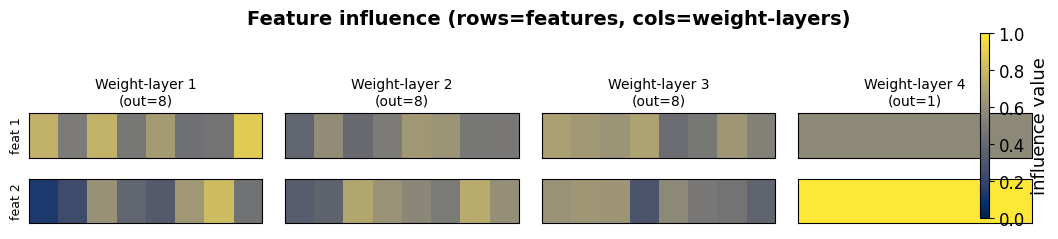

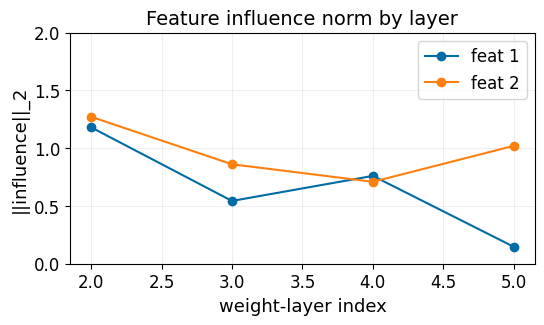

In [20]:
plot_feature_path(model_tf_y3, num_features=2, X_batch=X_L)

### Run Feature Path on ReLU experiment

[K^3 target] Test MSE — Input-ReLU: 0.015062, H1-ReLU: 0.003581, H2-ReLU: 0.002484, H3-ReLU: 0.002512


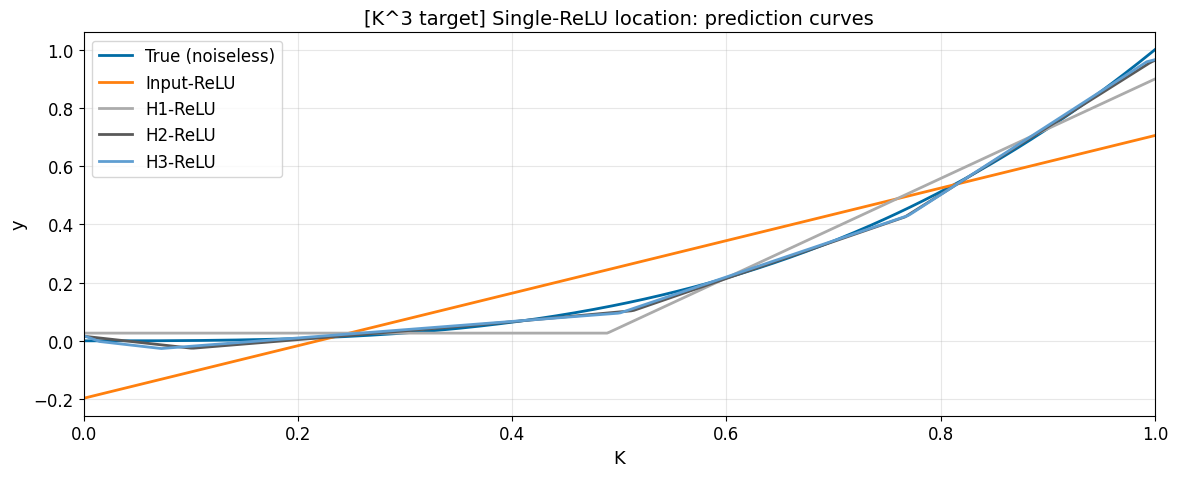

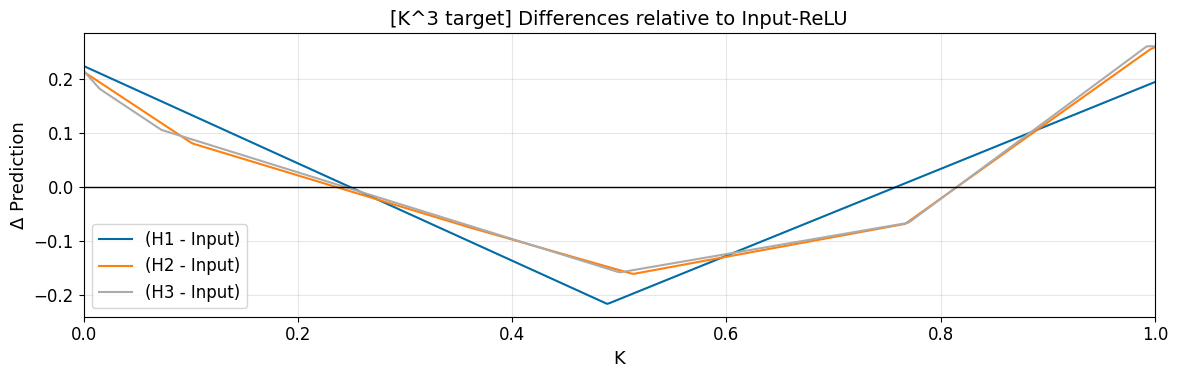

In [21]:
models_loc, X_tr_batch = run_single_relu_experiment(X_K, y1, K, xlabel="K",
                                                    title_prefix="K^3 target")

[Feature Path] Input-ReLU
(8,) 1.3522912907455922
(8,) 2.2696643919043638
(8,) 2.0224379886690245
(1,) 0.9026785598372704
(8,) 1.6662734988441936
(8,) 2.130142660808193
(8,) 2.693554657358631
(1,) 0.0622400338750313


/tmp/ipython-input-4192965540.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.95])


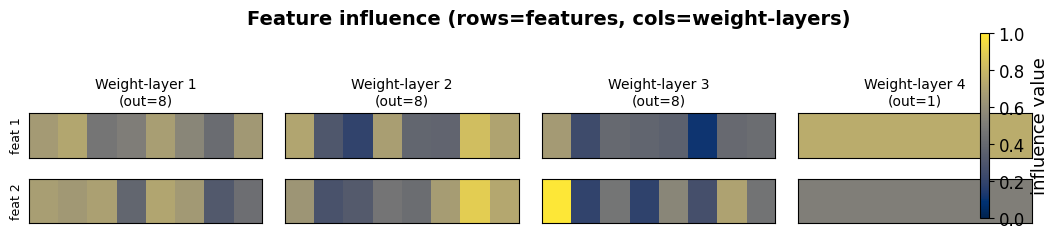

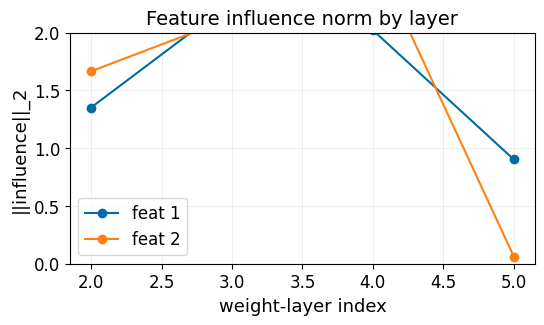

[Feature Path] H1-ReLU
(8,) 1.3727579156614882
(8,) 0.5044755549155471
(8,) 0.794646120475045
(1,) 0.8832710660520509
(8,) 1.1997862260502223
(8,) 0.2098584954274131
(8,) 0.33056753219299434
(1,) 0.3674349235956172


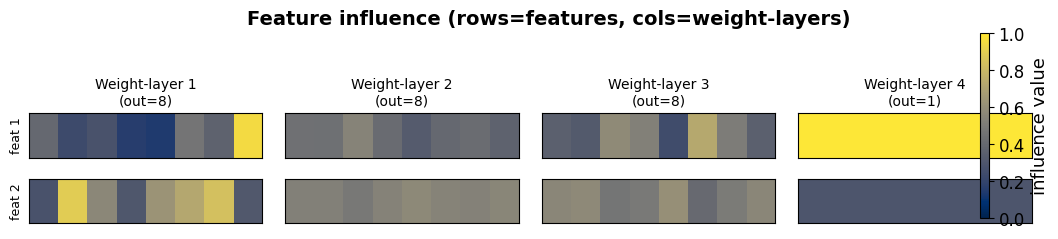

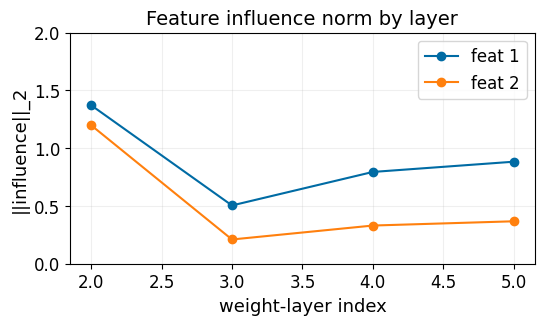

[Feature Path] H2-ReLU
(8,) 1.1932312427208587
(8,) 1.4470616609140734
(8,) 0.9764722571327209
(1,) 0.9477512759134625
(8,) 0.9709028077922812
(8,) 1.1611119246977324
(8,) 0.8295614922338092
(1,) 0.9803902968502033


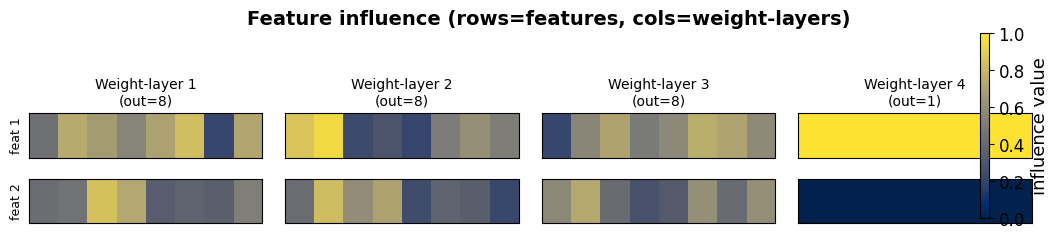

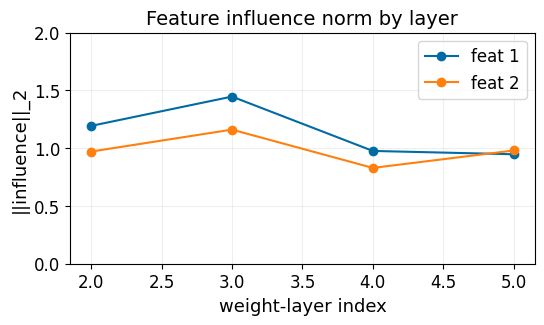

[Feature Path] H3-ReLU
(8,) 1.476527765054257
(8,) 2.041249453360403
(8,) 3.57473811969898
(1,) 0.9611094241199426
(8,) 1.1272969716979968
(8,) 1.051400886407807
(8,) 1.8414369541857507
(1,) 0.0943847329020699


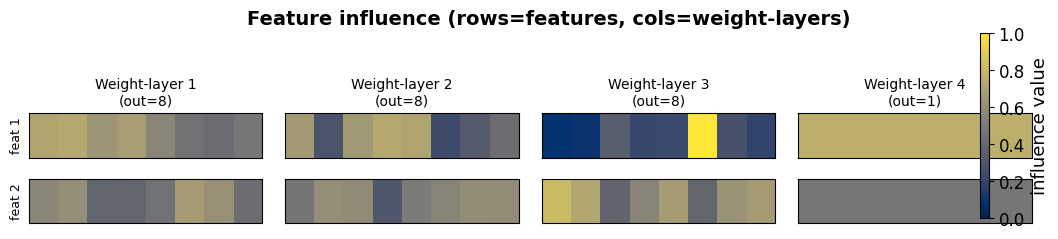

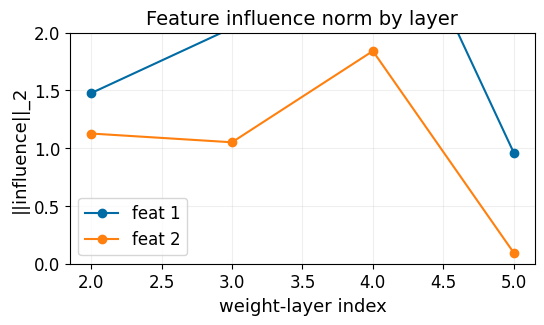

In [22]:
# num_features=2 → feat1=K, feat2=L
for name, m in models_loc.items():
    print(f"[Feature Path] {name}")
    plot_feature_path(m, num_features=2, X_batch=tf.convert_to_tensor(X_tr_batch, dtype=tf.float32))

### Back Propagation Visualize

In [ ]:
sorted_K = np.sort(X_K, axis=0)
sorted_L = np.sort(X_L, axis=0)

999 [np.float64(1.6682286139249014), np.float64(1.1632451074492096), np.float64(1.0224022725699584), np.float64(0.8035492566800699)] [1.66822861 1.16324511 1.02240227 0.80354926]


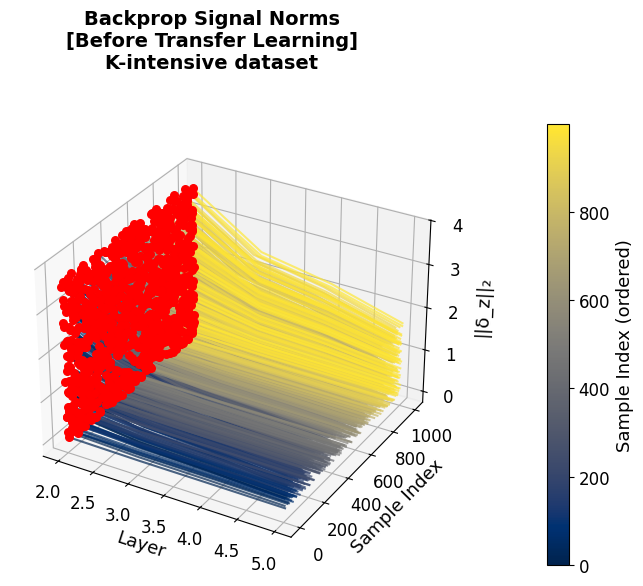

999 [np.float64(0.035637212314352254), np.float64(0.059034146967099264), np.float64(0.04479661885687943), np.float64(0.033062716468619795)] [0.03563721 0.05903415 0.04479662 0.03306272]


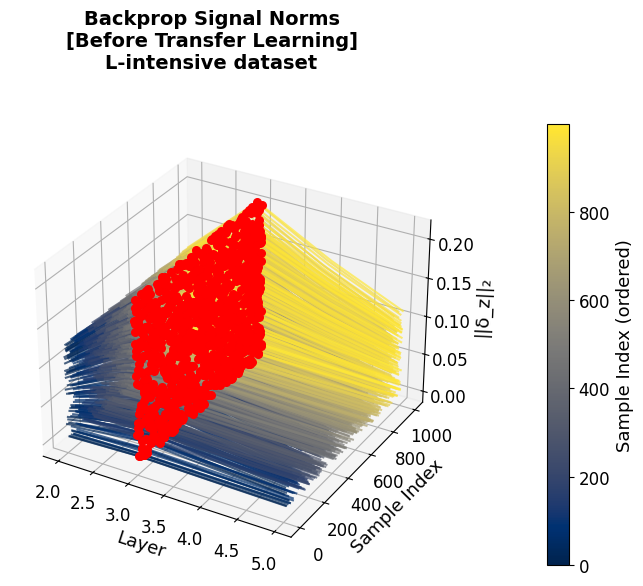

999 [np.float64(5.050528050475527), np.float64(3.697248126051683), np.float64(2.5630959685790025), np.float64(1.598657212139599)] [5.05052805 3.69724813 2.56309597 1.59865721]


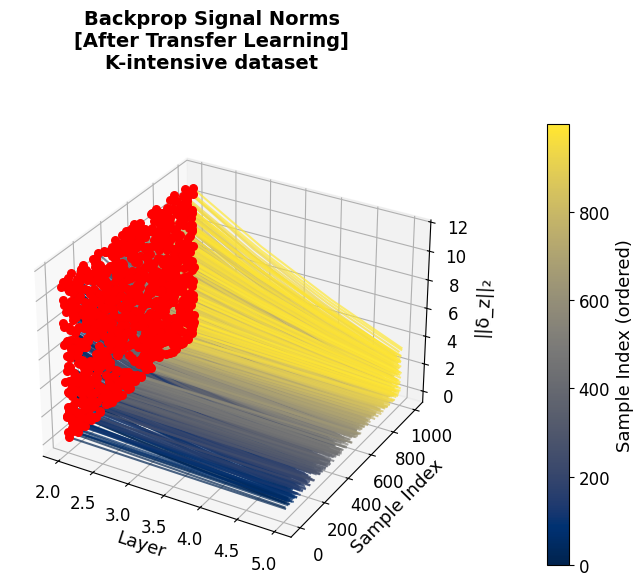

999 [np.float64(0.6824489821110187), np.float64(0.8686009973485319), np.float64(0.45270171721133057), np.float64(0.3080426646676846)] [0.68244898 0.868601   0.45270172 0.30804266]


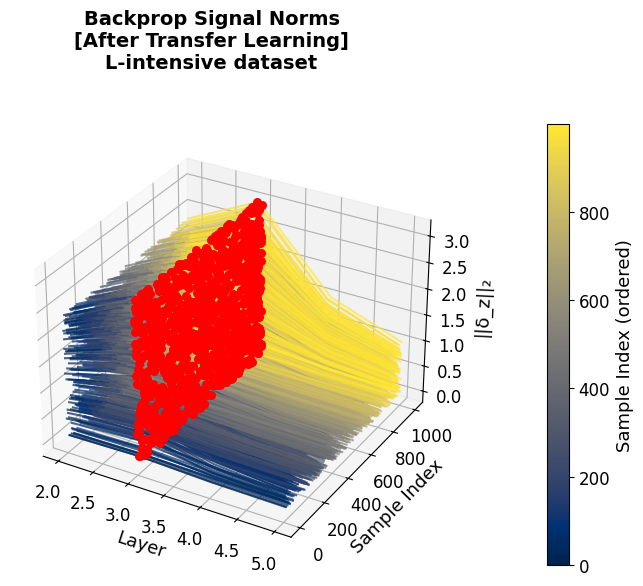

In [ ]:
models_before_after = {
  'Before Transfer Learning': model, 
  'After Transfer Learning': model_tf_y3
}
for im, vm in models_before_after.items():
  for i, d in enumerate([sorted_K, sorted_L]):
      plot_delta_flow(vm, d, subtitle=f'[{im}]\n{["K","L"][i]}-intensive dataset\n')